# Start Tensorflow with starttf

First we need to install tensorflow and check if it works.

In [0]:
!pip install tensorflow
import tensorflow as tf

In [2]:
print(tf.__version__)

1.7.0


Next let's install starttf and opendatalake

In [0]:
!pip install https://github.com/penguinmenac3/starttf/archive/master.zip
!pip install https://github.com/penguinmenac3/opendatalake/archive/master.zip

# Starting out

## Loading a dataset

Let's start by loading a dataset.
The simplest dataset for beginners is mnist.
The good thing about mnist is, that you do not need any complex downloading code.
Simply load it via the opendatalake.

In [0]:
from opendatalake.classification.mnist import mnist

base_dir = "data/mnist"

# Get a generator and its parameters
train_gen, train_gen_params = mnist(base_dir=base_dir, phase="train")
validation_gen, validation_gen_params = mnist(base_dir=base_dir, phase="validation")

# Create a generator to see some images
data = train_gen(train_gen_params)

Now you have downloaded the dataset and a generator which will output you labels and features.
Let's inspect some features and labels!

In [5]:
features, labels = next(data)
print(features.keys())
print(labels.keys())

dict_keys(['image'])
dict_keys(['probs'])


The image is a numpy array. Let's plot it using matplotlib. The label is one hot encoded probabilities. Using np.argmax you can receive the label of the image.

In the case of mnist the image is a 1d-array with 786 values. However, it actually represents a (28,28) image. So first you have to reshape it using numpy.

The Label is one hot encoded, this means you can use `np.argmax` to retrieve the index at which the one is (aka the label in human readable form).

Finally plot the image using matplotlibs imshow.

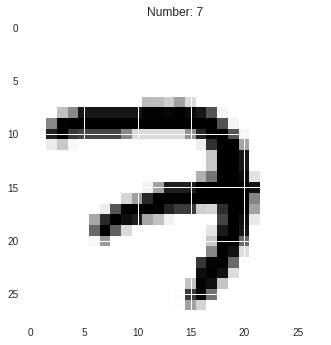

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Reshape image from (786,) to (28,28)
img = np.reshape(features['image'], (28,28))
number = np.argmax(labels['probs'])

# Plot img with number as title
plt.title("Number: %d" % number)
plt.imshow(img)
plt.show()

## Hyperparameters object

We need a hyperparams object to store all hyperparamters we setup for our training. Let's create one where we can add all variables.

In [0]:
from starttf.utils.dict2obj import Dict2Obj

hyper_params = Dict2Obj({})

## Preparing a training

Before writing a model, loss and everything fancy, you need to prepare your data for training.

In the case of mnist no cleaning or augmentation is required, so we can simply write the data into a tfrecord file.

However, to illustrate how data augmentation could work, we will set the data augmentation steps to 1 manually.
This involves adding a problem parameter to our hyper parameters.

In [0]:
from starttf.tfrecords.autorecords import write_data

# Let's define our learning problem
hyper_params.problem = Dict2Obj({"augmentation": {"steps": 1}})

write_data(hyper_params, "records/train", train_gen, train_gen_params, 4)
write_data(hyper_params, "records/validation", validation_gen, validation_gen_params, 2)

## Training a model (the easy way)

Now that the data is written into a format that we can efficiently read for training, let's have a look at an easy way to train a model.

First let's create a dict where to gather all hyperparameters for training. Usually you would put that in an extra .json file which can be loaded easily.

In [0]:
hyper_params_dict = {}

For simplicity we will use a predefined model (we will later see how to write a create model function by ourselves).

This model has a hyperparameter for `dropout_rate`

In [0]:
from starttf.models.mnist import create_model as mnist_model

hyper_params_dict["arch"] = {"dropout_rate": 0.5}

Next we need to define a loss.

The loss glues together our labels and the model.

In the case of mnist it is a simple cross entropy loss.

In [0]:
from starttf.utils.misc import mode_to_str

def create_loss(model, labels, mode, hyper_params):
    mode_name = mode_to_str(mode)
    metrics = {}

    # Add loss
    labels = tf.reshape(labels["probs"], [-1, 10])
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model["logits"], labels=labels))
    # For tensorboard, we don't use that now.
    #tf.summary.scalar(mode_name + '/loss', loss_op)
    metrics[mode_name + '/loss'] = loss_op

    return loss_op, metrics

Now we need to define all our hyperparameters and launch the training.

In [12]:
hyper_params_dict["train"] = {}
hyper_params_dict["train"]["checkpoint_path"] = "checkpoints"
hyper_params_dict["train"]["iters"] = 2000
hyper_params_dict["train"]["summary_iters"] = 250
hyper_params_dict["train"]["tf_records_path"] = "records"
hyper_params_dict["train"]["batch_size"] = 64
hyper_params_dict["train"]["validation_batch_size"] = 64
hyper_params_dict["train"]["learning_rate"] = {"type": "const", "start_value": 0.001}
hyper_params_dict["train"]["optimizer"] = {"type": "adam"}


hyper_params = Dict2Obj(hyper_params_dict)

from starttf.estimators.scientific_estimator import easy_train_and_evaluate

easy_train_and_evaluate(hyper_params, mnist_model, create_loss)

Using TensorFlow backend.


Loading data
Create training graph
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Create validation graph
Start training
Training Model: To reduce overhead no outputs are done. Use tensorboard to see your progress.
python -m tensorboard.main --logdir=checkpoints
Timing: 162.592 ms per iteration
Iter: 250, Train loss: 0.0691, Test loss: 0.1521
Timing: 95.804 ms per iteration
Iter: 500, Train loss: 0.0873, Test loss: 0.0662
Timing: 95.678 ms per iteration
Iter: 750, Train loss: 0.0938, Test loss: 0.0943
Timing: 95.158 ms per iteration
Iter: 1000, Train loss: 0.0268, Test loss: 0.1433
Timing: 96.877 ms per iteration
Iter: 1250, Train loss: 0.0831, Test loss: 0.0396
Timing: 96.615 ms per iteration
Iter: 1500, Train loss: 0.0307, Test loss: 0.1409
Timing: 95.890 ms per iteration
Iter: 1750, Train loss: 0.0171, Test loss: 0.1426
Timing: 95.224 ms per i

If you run this code on your native machine, you can visit the checkpoints path and find images there which contain plots of your metrics. In this case the loss.

## Training a model (a more involved way)

After having trained a model the easy way, let's do it the more involved way. In some cases the easy_train_and_evaluate might not fit your needs.

For training basically 4 steps are required:

1. Loading the data into a tensor
2. Defining the model
3. Defining the loss
4. Train and Evaluate the model given the loss

Then let's start with loading the data into a tensor.

In [0]:
from starttf.tfrecords.autorecords import read_data

train_features, train_labels = read_data("records/train", 64)
validation_features, validation_labels = read_data("records/validation", 64)

Next we define a model using those tensors.
Creating a model works by passing in an input_tensor, mode, and hyper params.

The mode tells the network if it has to run in evaluation, prediction or training mode.
When in eval mode, we want to resue the weights from the training network.
Otherwise the network would train and evaluate using different weights.

The Network we want to write is a little bit ispired by vgg just smaller. We have 2 conv layers, a pooling layer, 2 conv layers a pooling layer, dropout in training and finally some fully connected layer before a softmax layer.

In [0]:
def create_model(input_tensor, mode, hyper_params):
    model = {}
    
    with tf.variable_scope('SimpleMnistNetwork') as scope:
        if mode == tf.estimator.ModeKeys.EVAL:
            scope.reuse_variables()

        # Prepare the inputs
        x = tf.reshape(tensor=input_tensor["image"], shape=(-1, 28, 28, 1), name="input")

        # First Conv Block
        conv1 = tf.layers.conv2d(inputs=x, filters=16, kernel_size=(3, 3), strides=(1, 1), name="conv1",
                                 activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(inputs=conv1, filters=32, kernel_size=(3, 3), strides=(1, 1), name="conv2",
                                 activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2, 2), strides=(2, 2), name="pool2")

        # Second Conv Block
        conv3 = tf.layers.conv2d(inputs=pool2, filters=32, kernel_size=(3, 3), strides=(1, 1), name="conv3",
                                 activation=tf.nn.relu)
        conv4 = tf.layers.conv2d(inputs=conv3, filters=32, kernel_size=(3, 3), strides=(1, 1), name="conv4",
                                 activation=tf.nn.relu)
        pool4 = tf.layers.max_pooling2d(inputs=conv4, pool_size=(2, 2), strides=(2, 2), name="pool4")
        if mode == tf.estimator.ModeKeys.TRAIN:
            pool4 = tf.layers.dropout(inputs=pool4, rate=hyper_params.arch.dropout_rate, name="drop4")

        # Fully Connected Block
        probs = tf.layers.flatten(inputs=pool4)
        logits = tf.layers.dense(inputs=probs, units=10, activation=None, name="logits")
        probs = tf.nn.softmax(logits=logits, name="probs")

        # Collect outputs for api of network.
        model["pool2"] = pool2
        model["pool4"] = pool4
        model["logits"] = logits
        model["probs"] = probs
    return model

Now we have to create our model twice, once for training and once for evaluation.

In [0]:
train_model = create_model(train_features, tf.estimator.ModeKeys.TRAIN, hyper_params)
validation_model = create_model(validation_features, tf.estimator.ModeKeys.EVAL, hyper_params)

As a loss we can use the same as for the easy training way.
We need to create it once for training and once for validation.

In [0]:
train_loss, train_metrics = create_loss(train_model, train_labels, tf.estimator.ModeKeys.TRAIN, hyper_params)
validation_loss, validation_metrics = create_loss(validation_model, validation_labels, tf.estimator.ModeKeys.EVAL, hyper_params)

Next we need to define a training operation to be able to train our model. In this case we will use a default adam optimizer, it should work ok.

In [0]:
train_op = tf.train.AdamOptimizer().minimize(train_loss)

The only thing left is actually training our model.
Since we can reuse the hyperparameters from the simple training method. This ensures comparability.

In [18]:
from starttf.utils.plot_losses import DefaultLossCallback
from starttf.utils.session_config import get_default_config
from starttf.estimators.scientific_estimator import train_and_evaluate

with tf.Session(config=get_default_config()) as session:
        checkpoint_path = train_and_evaluate(hyper_params, session, train_op,
                                             metrics=[train_metrics, validation_metrics],
                                             callback=DefaultLossCallback().callback,
                                             enable_timing=True)

Training Model: To reduce overhead no outputs are done. Use tensorboard to see your progress.
python -m tensorboard.main --logdir=checkpoints
Timing: 177.183 ms per iteration
Iter: 250, Train loss: 0.0493, Test loss: 0.0889
Timing: 94.161 ms per iteration
Iter: 500, Train loss: 0.0779, Test loss: 0.1184
Timing: 94.884 ms per iteration
Iter: 750, Train loss: 0.0751, Test loss: 0.1157
Timing: 96.057 ms per iteration
Iter: 1000, Train loss: 0.0905, Test loss: 0.0910
Timing: 96.221 ms per iteration
Iter: 1250, Train loss: 0.0078, Test loss: 0.0361
Timing: 96.063 ms per iteration
Iter: 1500, Train loss: 0.0406, Test loss: 0.1907
Timing: 95.023 ms per iteration
Iter: 1750, Train loss: 0.1314, Test loss: 0.0044
Timing: 95.445 ms per iteration


Congratulations!

When you now want to work on a different dataset you have to do basically the same.

## How to do that on something else than mnist?

1. Write a data generator, like the mnist generator we used. (See [mnist here](https://github.com/penguinmenac3/opendatalake/blob/master/opendatalake/classification/mnist.py) or a named folder based loader [here](https://github.com/penguinmenac3/opendatalake/blob/master/opendatalake/classification/named_folders.py))
```python
def threadable_gen(params, stride=1, offset=0, infinite=False):
        # This function cannot be a lambda or pooling does not work.
        # All interactions with the outside world must be via the params object. (agian for pooling to work)
        # yield dicts for features and labels
```
2. Prepare your data as we have done here using the write_data method. You can optionally pass in a data augmentation, label_preprocessing and feature_preprocessing method if you want to.
```python
def write_data(hyper_params,
               prefix,
               threadable_generator,
               params,
               num_threads,
               preprocess_feature=None,
               preprocess_label=None,
               augment_data=None):
```
3. Write a model or use a predefined one. There are implementations of common models in starttf.models. You can find vgg16 there for example. If you have an awesome model, consider a pull request at [starttf project on github](https://github.com/penguinmenac3/starttf/)
```python
def create_model(input_tensor, mode, hyper_params):
        # Do not forget reuse variables and variable scope!
```
4. Write a loss like we did here to glue together your model and the labels.
```python
def create_loss(model, labels, mode, hyper_params):
        # Return a loss op and metrics dict (like shown in this notebook)
        # If you need some advanced losses, consider using starttf.losses. (alpha balancing, focus loss, mask loss, ...)
```
5. Use the easy_train_and_evaluate method or write your own training logic. Here we used a train_and_evaluate method, if you need some specific training that it cannot do you can use the source code [here](https://github.com/penguinmenac3/starttf/blob/master/starttf/estimators/scientific_estimator.py) and modify it to your requirements. If it is of general interest and has good code quality, consider pull requesting. ;)
```python
def easy_train_and_evaluate(hyper_params, create_model, create_loss, init_model=None):
        # Init Model is a callback that you can use to initialize your model with pretrained weights just before training starts.
```

Stick to those patterns and writing a model for example 3d-detection of vehicles in realtime is done with just as many lines of code as writing an mnist network.
Trust me on that one. I tried it myself. ;)